# SSD with Albumentations

In [1]:
!pip install -q albumentations==0.5.1
import albumentations as A
A.__version__

'0.5.1'

In [2]:
import torch
torch.__version__

'1.7.0+cu101'

In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
!pip install -q pytorch_lightning==1.0.8
import pytorch_lightning as pl
pl.__version__

'1.0.8'

In [5]:
pl.seed_everything(0)

0

In [6]:
!git clone https://github.com/nakabeppu/ssd_pytorch-lightning

fatal: destination path 'ssd_pytorch-lightning' already exists and is not an empty directory.


In [7]:
%cd ssd_pytorch-lightning/

/content/ssd_pytorch-lightning


## Check Albumentations

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# 1 sample
image_path = 'data/Aerial Maritime.v9-tiled.voc/train/DJI_0258_JPG.rf.0c4380c012e940ff668b008ffe35a52c.jpg'
image = Image.open(image_path)
image = np.array(image)
image.shape

(600, 800, 3)

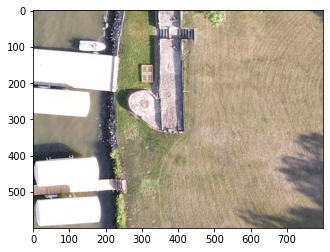

In [10]:
plt.imshow(image);

In [11]:
from xml.etree.ElementTree import parse

In [12]:
# target

aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

anno_path = 'data/Aerial Maritime.v9-tiled.voc/train/DJI_0258_JPG.rf.0c4380c012e940ff668b008ffe35a52c.xml'
parser = parse(anno_path)
bboxes = []
for obj in parser.findall('object'):
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    name = obj.find('name').text
    bboxes.append([xmin, ymin, xmax, ymax, name])

In [13]:
bboxes

[[1, 92, 258, 235, 'dock'],
 [1, 440, 255, 537, 'dock'],
 [1, 208, 166, 303, 'lift'],
 [1, 393, 186, 481, 'lift'],
 [8, 524, 188, 593, 'lift']]

In [14]:
from PIL import ImageDraw, ImageFont

In [15]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [16]:
def visualize_boxes(image, targets):

    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 16)
    for target in targets:
        # box
        box = target[:4]
        draw.rectangle(box, outline='red')
        # label
        text = target[4]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0]+w, box[1]+h], fill='red')
        draw.text((box[0], box[1]), text, font=font, fill='white')

    return image

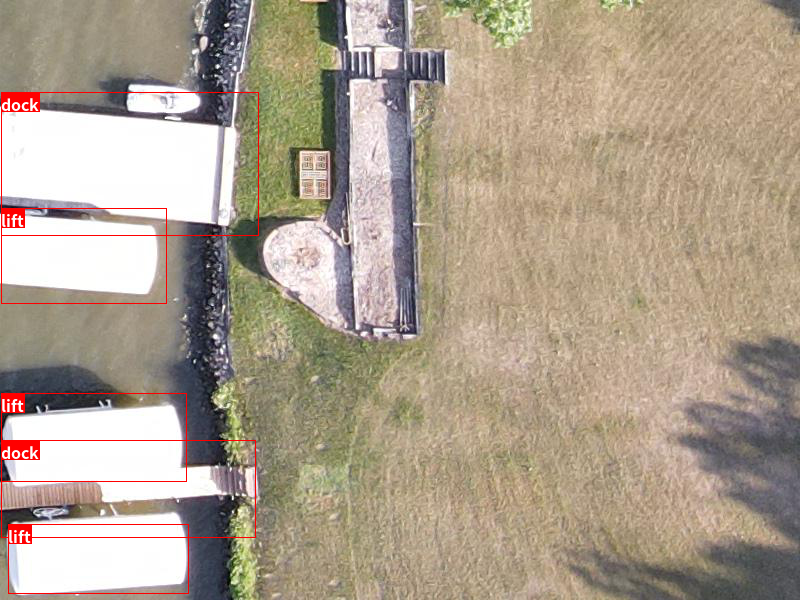

In [17]:
# check
visualize_boxes(image, bboxes)

In [18]:
bbox_params = A.BboxParams(format='pascal_voc')
bbox_params

In [19]:
# HorizontalFlip
transform = A.Compose(
              [ A.HorizontalFlip(p=1.0) ],
              bbox_params=bbox_params)

In [20]:
# transform
transformed = transform(image=image, bboxes=bboxes)

In [21]:
transformed['image'].shape

(600, 800, 3)

In [22]:
transformed['bboxes']

[(542.0, 92.0, 799.0, 235.0, 'dock'),
 (545.0, 439.99999999999994, 799.0, 537.0, 'dock'),
 (634.0, 208.0, 799.0, 303.0, 'lift'),
 (614.0, 393.0, 799.0, 481.0, 'lift'),
 (612.0, 524.0, 792.0, 593.0, 'lift')]

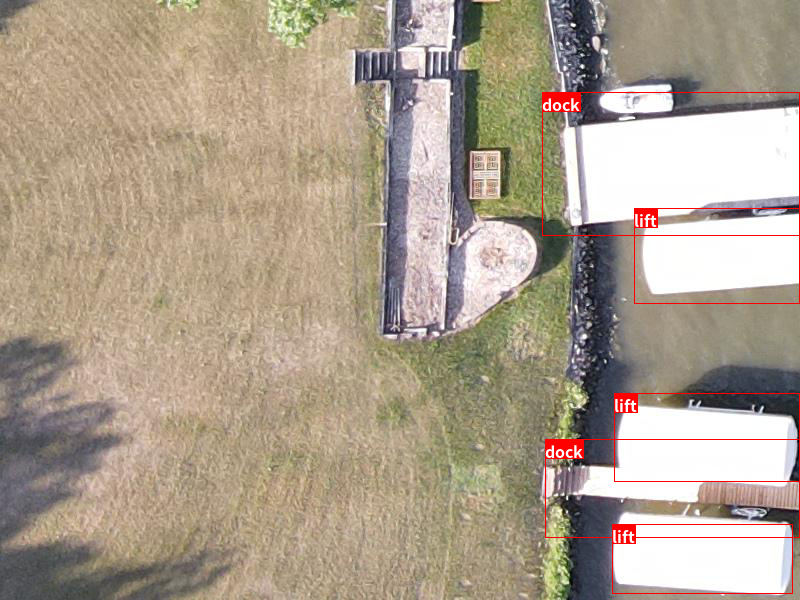

In [23]:
# check
visualize_boxes(transformed['image'], transformed['bboxes'])

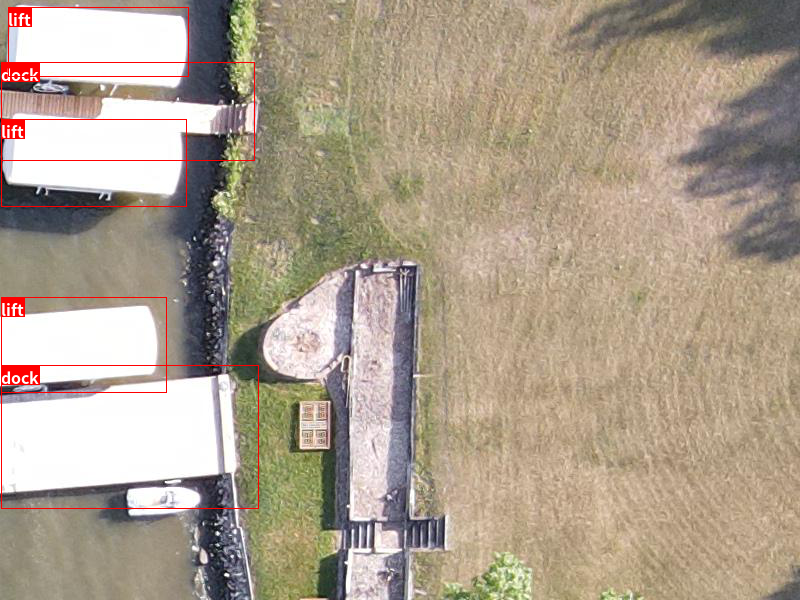

In [24]:
# VerticalFlip
transform = A.Compose(
              [ A.VerticalFlip(p=1.0) ],
              bbox_params=bbox_params)

# transform
transformed = transform(image=image, bboxes=bboxes)

# check
visualize_boxes(transformed['image'], transformed['bboxes'])

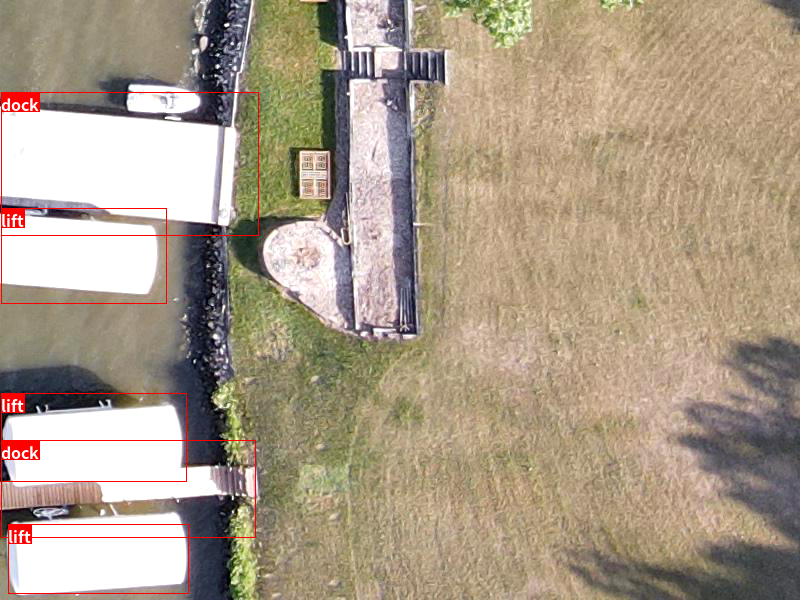

In [25]:
# RandomBrightnessContrast
transform = A.Compose(
              [ A.RandomBrightnessContrast(p=1.0) ],
              bbox_params=bbox_params)

# transform
transformed = transform(image=image, bboxes=bboxes)

# check
visualize_boxes(transformed['image'], transformed['bboxes'])

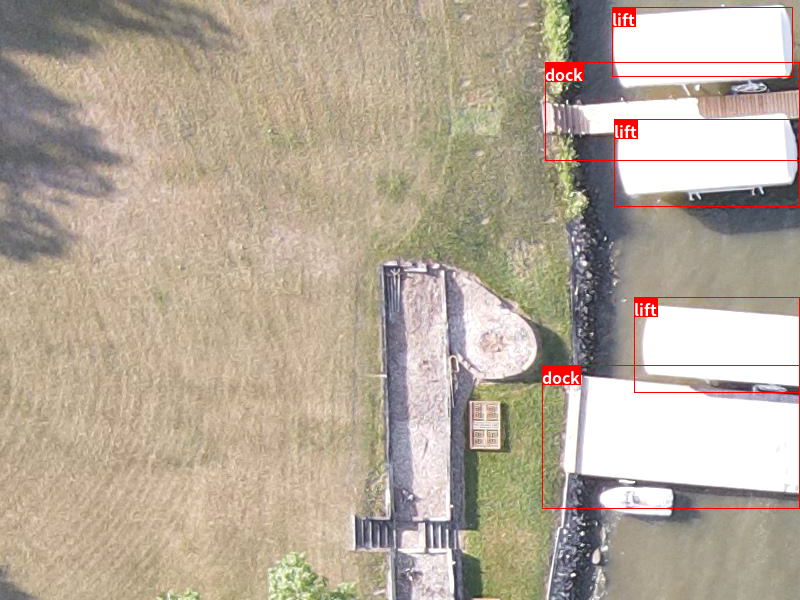

In [26]:
# all transform
transform = A.Compose([
                A.HorizontalFlip(p=1.0),
                A.VerticalFlip(p=1.0),
                A.RandomBrightnessContrast(p=1.0)
              ], bbox_params=bbox_params)

# transform
transformed = transform(image=image, bboxes=bboxes)

# check
visualize_boxes(transformed['image'], transformed['bboxes'])

In [27]:
from albumentations.pytorch import ToTensor

In [28]:
transform = A.Compose([
                A.HorizontalFlip(p=1.0),
                A.VerticalFlip(p=1.0),
                A.RandomBrightnessContrast(p=1.0),
                A.Resize(300, 300),
                ToTensor()
              ], bbox_params=bbox_params)

# transform
transformed = transform(image=image, bboxes=bboxes)

In [29]:
type(transformed['image'])

torch.Tensor

In [30]:
transformed['image'].dtype

torch.float32

In [31]:
transformed['image'].shape

torch.Size([3, 300, 300])

In [32]:
transformed['image']

tensor([[[0.5294, 0.5373, 0.5216,  ..., 0.8431, 0.8510, 0.8588],
         [0.5176, 0.5608, 0.5412,  ..., 0.8549, 0.8471, 0.8510],
         [0.5176, 0.5333, 0.5451,  ..., 0.8588, 0.8471, 0.8471],
         ...,
         [0.5765, 0.5490, 0.5529,  ..., 0.7804, 0.7725, 0.8039],
         [0.5686, 0.5412, 0.5373,  ..., 0.7725, 0.7765, 0.7843],
         [0.5451, 0.5608, 0.5647,  ..., 0.7882, 0.8078, 0.7765]],

        [[0.5333, 0.5412, 0.5255,  ..., 0.8118, 0.8196, 0.8275],
         [0.5216, 0.5647, 0.5451,  ..., 0.8314, 0.8196, 0.8196],
         [0.5216, 0.5373, 0.5490,  ..., 0.8353, 0.8196, 0.8157],
         ...,
         [0.5804, 0.5529, 0.5529,  ..., 0.7725, 0.7569, 0.7882],
         [0.5804, 0.5490, 0.5412,  ..., 0.7647, 0.7608, 0.7725],
         [0.5608, 0.5686, 0.5686,  ..., 0.7804, 0.7922, 0.7647]],

        [[0.5490, 0.5569, 0.5412,  ..., 0.7294, 0.7373, 0.7451],
         [0.5412, 0.5843, 0.5647,  ..., 0.7333, 0.7333, 0.7412],
         [0.5412, 0.5569, 0.5647,  ..., 0.7294, 0.7294, 0.

In [33]:
transformed['bboxes']

[(203.25, 182.50000000000003, 299.625, 254.0, 'dock'),
 (204.375, 31.499999999999993, 299.625, 80.00000000000001, 'dock'),
 (237.75, 148.5, 299.625, 196.0, 'lift'),
 (230.25, 59.50000000000001, 299.625, 103.49999999999999, 'lift'),
 (229.5, 3.500000000000014, 297.0, 38.000000000000014, 'lift')]

## Make Dataset with Albumentations

In [34]:
from glob import glob

In [35]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, root, mode='train'):
        self.root = root
        self.mode = mode
        self.aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']
        self.data_list = sorted(glob(f'{root}/{mode}/*xml'))

        bbox_params = A.BboxParams(format='pascal_voc')
        
        # 訓練時のみデータ拡張の変換
        if self.mode == 'train':
            self.transform = A.Compose([
                A.Resize(300, 300),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
                ToTensor()
              ], bbox_params=bbox_params)
            
        # 検証とテストデータにはデータ拡張の処理はなし
        else:
            self.transform = A.Compose([
                A.Resize(300, 300),
                ToTensor()
              ], bbox_params=bbox_params)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        parser = parse(data)

        # 入力値
        img_path = parser.find('filename').text
        img_path = f'{self.root}/{self.mode}/{img_path}'
        img = Image.open(img_path)
        img = np.array(img)


        # 目標値
        bboxes = []
        for obj in parser.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text) - 1
            ymin = int(bbox.find('ymin').text) -1
            xmax = int(bbox.find('xmax').text) -1
            ymax = int(bbox.find('ymax').text) -1
            name = obj.find('name').text
            bboxes.append([xmin, ymin, xmax, ymax, name])

        # データ拡張
        transformed = self.transform(image=img, bboxes=bboxes)
        image = transformed['image']
        w = image.shape[1]
        h = image.shape[2]

        transformed_target = []
        for target in transformed['bboxes']:
            x_min, y_min, x_max, y_max, name = target
            label = int(self.aerial_maritime_labels.index(name))
            transformed_target.append([x_min/w, y_min/h, x_max/w, y_max/h, label])
        targets = torch.tensor(transformed_target, dtype=torch.float32)

        return image, targets

    def __len__(self):
        return len(self.data_list)

In [36]:
# get the dataset
root = 'data/Aerial Maritime.v9-tiled.voc'
train = Dataset(root, mode='train')
val = Dataset(root, mode='valid')
test = Dataset(root, mode='test')

In [37]:
len(train), len(val), len(test)

(371, 105, 32)

In [38]:
x, t = train[0]

In [39]:
x.shape

torch.Size([3, 300, 300])

In [40]:
t

tensor([[0.0000, 0.6100, 0.3212, 0.8483, 0.0000],
        [0.0000, 0.1067, 0.3175, 0.2683, 0.0000],
        [0.0000, 0.4967, 0.2062, 0.6550, 2.0000],
        [0.0000, 0.2000, 0.2313, 0.3467, 2.0000],
        [0.0088, 0.0133, 0.2338, 0.1283, 2.0000]])

In [41]:
def visualize_results(input, outputs):

    img= input.permute(1, 2, 0).numpy()
    image = Image.fromarray((img*255).astype(np.uint8))

    aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

    scale = torch.Tensor(img.shape[1::-1]).repeat(2)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 16)

    for output in outputs:
        box = (output[:4]*scale).cpu().numpy()# スケールを揃える
        label_name = aerial_maritime_labels[int(output[4])]
        w, h = font.getsize(label_name)
        draw.rectangle(box, outline='red', width=5)
        draw.rectangle([box[0], box[1], box[0]+w, box[1]+h], fill='red')
        draw.text((box[0], box[1]), label_name, font=font, fill='white')

    return image

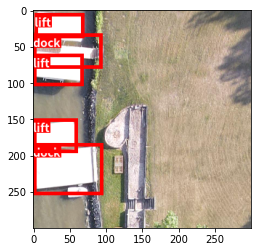

In [42]:
image = visualize_results(x, t)
plt.imshow(image);

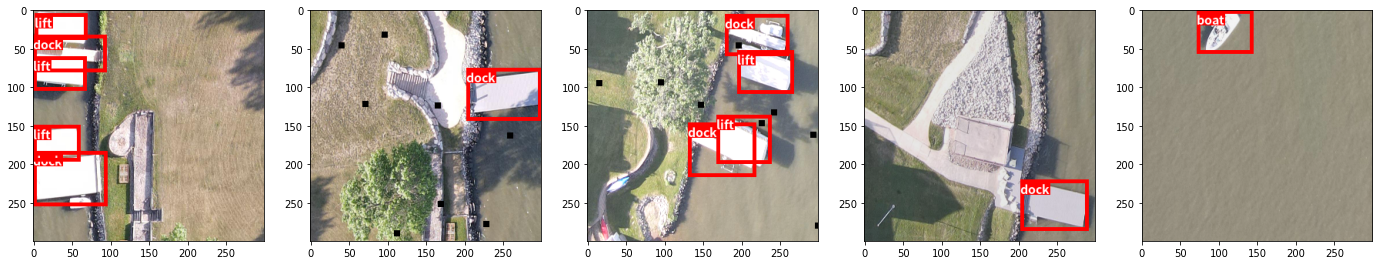

In [43]:
# 5 samples check
plt.figure(figsize=(24, 20))
for n in range(5):
    x, t = train[n]
    result = visualize_results(x, t)
    plt.subplot(1, 5, n+1)
    plt.imshow(result)

In [44]:
# Make DataLoader
pl.seed_everything(0)

def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

# batch size
batch_size = 8

# Data Loader 
aug_train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size, collate_fn=collate_fn)

## Create the Model

In [45]:
from SSDNet import *

In [46]:
import os
import urllib.request

weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# SSD の重み
url = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'
target_path = os.path.join(weights_dir, "ssd_300.pth")

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [47]:
net = Net()
net.load_state_dict(torch.load('weights/ssd_300.pth'))

<All keys matched successfully>

## Train

In [ ]:
pl.seed_everything(0)
new_conf = conf(num_classes=6)
net.conf = new_conf
net.num_classes=6
# Train
trainer = pl.Trainer(max_epochs=50, gpus=1, deterministic=True)
trainer.fit(net, aug_train_loader, val_loader)

In [49]:
# evaluate
results = trainer.test(test_dataloaders=test_loader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(4.0214, device='cuda:0'),
 'train_loss': tensor(1.1846, device='cuda:0'),
 'train_loss_epoch': tensor(1.6324, device='cuda:0'),
 'train_loss_step': tensor(1.1846, device='cuda:0'),
 'val_loss': tensor(3.8557, device='cuda:0')}
--------------------------------------------------------------------------------



In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Test

In [51]:
torch.save(net.state_dict(), 'ssd.pt')

In [52]:
net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt'))

<All keys matched successfully>

In [53]:
# 1 sample
x, t = test[0]
y = net(x.unsqueeze(0))

In [54]:
y.shape

torch.Size([1, 6, 200, 5])

In [55]:
y[0].shape

torch.Size([6, 200, 5])

In [56]:
y[0][1][0]

tensor([0.3042, 0.2354, 0.6324, 0.4252, 0.7915])

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [58]:
def visualize_results(input, outputs, threshold):

    img= input.permute(1, 2, 0).numpy()
    image = Image.fromarray((img*255).astype(np.uint8))

    aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

    scale = torch.Tensor(img.shape[1::-1]).repeat(2)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 16)

    for i in range(outputs.size(1)):
        j = 0
        while outputs[0,i,j,0] >= threshold:
            score = outputs[0,i,j,0]
            label_name = aerial_maritime_labels[i-1]
            boxes = (outputs[0,i,j,1:]*scale).cpu().numpy()
            draw.rectangle(boxes, outline='red', width=5)
            w, h = font.getsize(label_name)
            draw.rectangle([boxes[0], boxes[1], boxes[0]+w, boxes[1]+h], fill='red')
            draw.text((boxes[0], boxes[1]), label_name, font=font, fill='white')
            j+=1

    return image

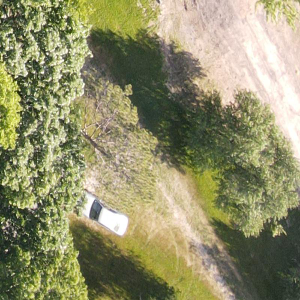

In [59]:
visualize_results(x, y, threshold=0.5)

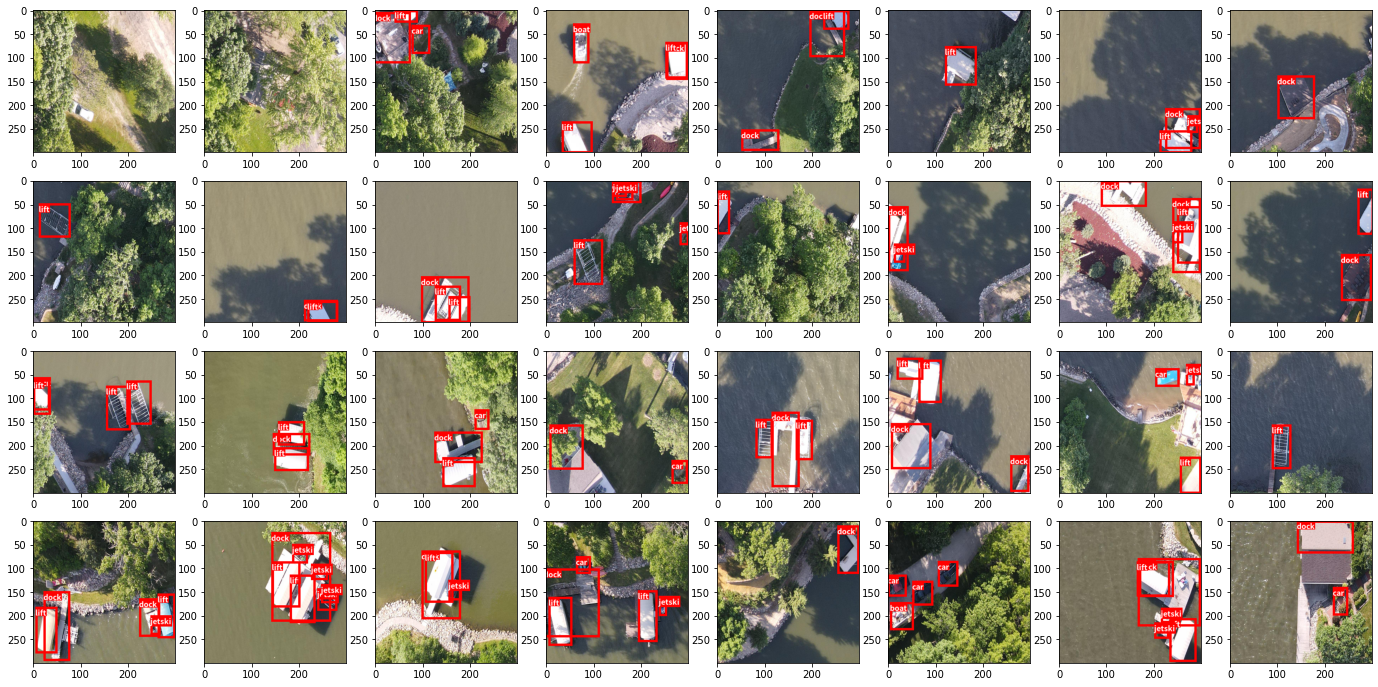

In [60]:
# all test images
plt.figure(figsize=(24, 12))
net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt', map_location=torch.device('cpu')))
for n in range(len(test)):
    x, t = test[n]
    y = net(x.unsqueeze(0))
    image = visualize_results(x, y, threshold=0.5)
    plt.subplot(4, 8, n+1)
    plt.imshow(image)

## mAP

In [61]:
!git clone https://github.com/Cartucho/mAP

fatal: destination path 'mAP' already exists and is not an empty directory.


In [62]:
import os

# delete file
dr_paths = glob('mAP/input/detection-results/*')
for path in dr_paths:
    os.remove(path)
gt_paths = glob('mAP/input/ground-truth/*')
for path in gt_paths:
    os.remove(path)

In [72]:
# ground-truth
import xml.etree.ElementTree as ET

xml_list = glob('data/Aerial Maritime.v9-tiled.voc/test/*.xml')

for tmp_file in xml_list:
    with open(tmp_file.replace(".xml", ".txt"), "a") as new_f:
        root = ET.parse(tmp_file).getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        for obj in root.findall('object'):
            obj_name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text) / w
            ymin = int(bndbox.find('ymin').text) / h
            xmax = int(bndbox.find('xmax').text) / w
            ymax = int(bndbox.find('ymax').text) / h
            new_f.write("%s %s %s %s %s\n" % (obj_name, xmin, ymin, xmax, ymax))
print("Conversion completed!")

Conversion completed!


In [73]:
import shutil
# move ground-truth 
ground_truth_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*.txt'))
for gt_file in ground_truth_paths:
    shutil.move(gt_file, 'mAP/input/ground-truth/')

In [74]:
# detection-results 
test_image_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*jpg'))

net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt', map_location=torch.device('cpu')))

aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

for test_image_path in test_image_paths:

    image = Image.open(test_image_path)
    transform = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
    img = transform(image)
    outputs = net(img.unsqueeze(0))

    with open(test_image_path.replace('.jpg', '.txt'), 'a') as new_f:
        for i in range(outputs.size(1)):
            j = 0
            while outputs[0,i,j,0] >= 0.1:
                score = outputs[0, i, j, 0].numpy()
                label_name = aerial_maritime_labels[i-1]
                boxes = (outputs[0,i,j,1:]).cpu().numpy()
                xmin, ymin, xmax, ymax = boxes
                new_f.write("%s %s %s %s %s %s\n" % (label_name, score, xmin, ymin, xmax, ymax))
                j += 1
print("Conversion completed!")

Conversion completed!


In [75]:
# move detection-result
detection_results_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*.txt'))
for dr_file in detection_results_paths:
    shutil.move(dr_file, 'mAP/input/detection-results/')

In [76]:
%cd mAP/

/content/ssd_pytorch-lightning/mAP


In [77]:
# mAP
!python3 main.py -na

40.74% = boat AP 
61.15% = car AP 
70.29% = dock AP 
75.53% = jetski AP 
82.98% = lift AP 
mAP = 66.14%
<Figure size 640x480 with 1 Axes>
